In [2]:
from sklearn.datasets import fetch_openml

In [3]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist['data'], mnist['target']

In [5]:
X.shape

(70000, 784)

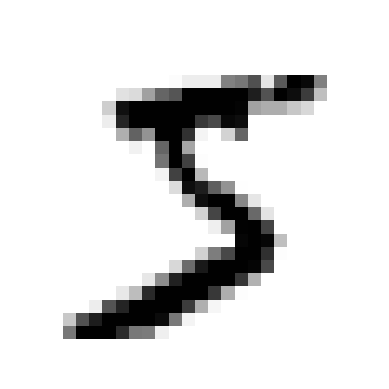

'5'

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_img = some_digit.reshape(28, 28)

plt.imshow(some_digit_img, cmap='binary')
plt.axis('off')
plt.show()
y[0]

In [7]:
import numpy as np
y = y.astype(np.uint8)

In [8]:
X_train, X_test, y_train, y_test = X[:60_000], X[60_000:], y[:60_000], y[60_000:]

In [9]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [10]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [13]:
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

In [14]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    X_test_fold = X_train[test_index]
    y_train_folds = y_train[train_index]
    y_test_fold = y_train[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.8642
0.87215
0.88795


In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [16]:
from sklearn.base import BaseEstimator
import numpy as np

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [17]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [18]:
# creating confusiuon matrix
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [19]:
from sklearn.metrics import confusion_matrix

In [20]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [21]:
y_perfect_pred = y_train_5
confusion_matrix(y_train_5, y_perfect_pred)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [22]:
from sklearn.metrics import precision_score, recall_score

In [23]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [24]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [25]:
from sklearn.metrics import f1_score

In [26]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [27]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [28]:
from sklearn.metrics import precision_recall_curve

In [29]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

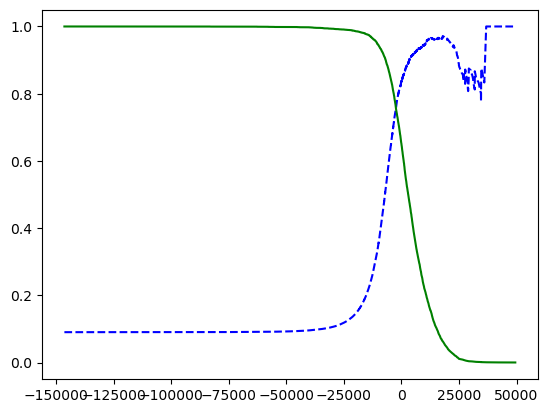

In [30]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recalls')
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [31]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]

In [32]:
threshold_90_precision

3370.0194991439594

In [33]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [34]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [35]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [36]:
from sklearn.metrics import roc_curve

In [37]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [38]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=label, linewidth=2)
    plt.plot([0, 1], [0, 1])

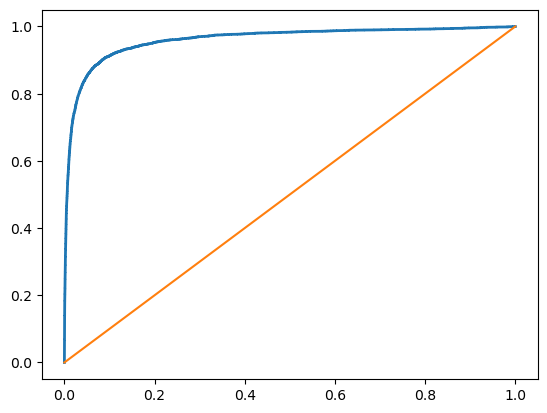

In [39]:
plot_roc_curve(fpr, tpr)
plt.show()

In [40]:
from sklearn.metrics import roc_auc_score

In [41]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [42]:
from sklearn.ensemble import RandomForestClassifier

In [43]:
forest = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest, X_train, y_train_5, cv=3, method='predict_proba')

In [44]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

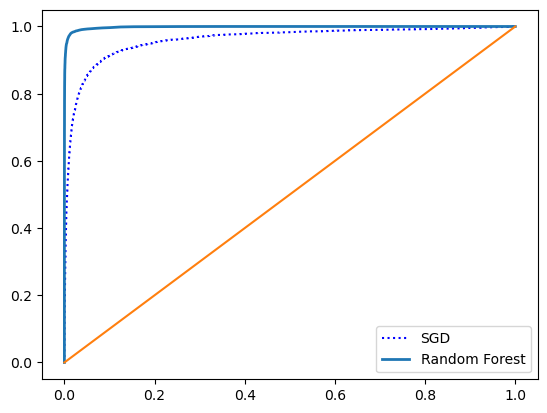

In [45]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [46]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [47]:
forest_scores = cross_val_predict(forest, X_train, y_train_5, cv=3)

In [48]:
precision_score(y_train_5, forest_scores)

0.9905083315756169

In [49]:
recall_score(y_train_5, forest_scores)

0.8662608374838591

In [50]:
f1_score(y_train_5, forest_scores)

0.9242275142688446

In [51]:
from sklearn.svm import SVC

In [52]:
svm_clf = SVC()

In [53]:
svm_clf.fit(X_train, y_train)

SVC()

In [54]:
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [55]:
some_digit_scores = svm_clf.decision_function([some_digit])

In [56]:
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [57]:
svm_scores = svm_clf.decision_function(X_train)

In [59]:
from sklearn.multiclass import OneVsRestClassifier

In [60]:
ovr_clf = OneVsRestClassifier(SVC())

In [61]:
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [64]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [65]:
from sklearn.preprocessing import StandardScaler

In [66]:
scaler = StandardScaler()

In [67]:
import numpy as np
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [68]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [69]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [70]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [72]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605